In [27]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from influenza_USA.NC_forecasts.utils import get_NC_influenza_data

## Forecast figure 

In [28]:
# settings
season = '2023-2024'
filename = '2023-12-30-JHU_IDD-hierarchSIM.csv'
start_visualisation = datetime(int(season[0:4]), 11, 1)
# load in prediction
simout = pd.read_csv(filename)
simout['reference_date'] = pd.to_datetime(simout['reference_date'])
# get reference date
stop_data_train = simout['reference_date'].unique()[0] - timedelta(weeks=1)
# load training and validation data
data_train = get_NC_influenza_data(start_visualisation, stop_data_train, season)['H_inc']*7
data_forecast = get_NC_influenza_data(stop_data_train+timedelta(weeks=1), stop_data_train+timedelta(weeks=4), season)['H_inc']*7

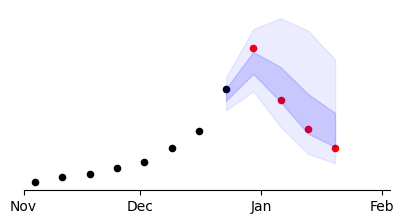

In [29]:
fig,ax=plt.subplots(figsize=(8.3/2, 11.7/5))

# visualise data
ax.scatter(data_train.index, data_train, marker='o', s=20, color='black')
ax.scatter(data_forecast.index, data_forecast, marker='o', s=20, color='red')
# visualise model
x = simout['target_end_date'].unique()
ax.fill_between(x, np.squeeze(simout[simout['output_type_id'] == 0.025][['value']].values),
                    np.squeeze(simout[simout['output_type_id'] == 1-0.025][['value']].values),
                       color='blue', alpha=0.075)
ax.fill_between(x, np.squeeze(simout[simout['output_type_id'] == 0.25][['value']].values),
                    np.squeeze(simout[simout['output_type_id'] == 0.75][['value']].values),
                       color='blue', alpha=0.15)
# no spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
# months only
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
# no ticks
ax.set_yticks([])
# xlims
ax.set_xlim([start_visualisation, stop_data_train+timedelta(weeks=6)])
plt.tight_layout()
plt.savefig(f'{filename[:-4]}.pdf')
plt.show()
plt.close()

## Whole-season fit figures

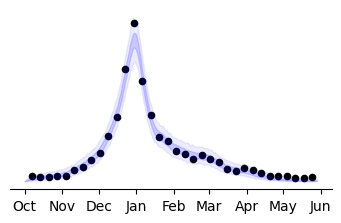

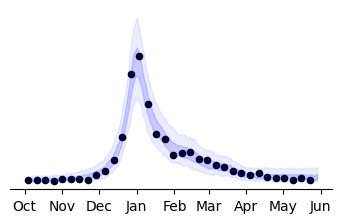

In [31]:
seasons = ['2014-2015', '2023-2024']
filenames = ['end-2024-04-06_simulation-output.nc', 'end-2015-04-04_simulation-output.nc']
for season, filename in zip(seasons, filenames):
    # get simulation
    simout = xr.open_dataset(filename) * 7
    # get data
    data = get_NC_influenza_data(min(simout.date.values), max(simout.date.values), season)['H_inc']*7
    # make a figure
    fig,ax=plt.subplots(figsize=(8.3/2, 11.7/5))
    ## data
    ax.scatter(data.index, data, marker='o', s=20, color='black')
    ## model
    x = simout.date.values
    ax.fill_between(x, simout['H_inc'].sum(dim=['age_group', 'location']).quantile(q=0.025, dim='draws').values,
                        simout['H_inc'].sum(dim=['age_group', 'location']).quantile(q=1-0.025, dim='draws').values,
                           color='blue', alpha=0.075)
    ax.fill_between(x, simout['H_inc'].sum(dim=['age_group', 'location']).quantile(q=0.25, dim='draws').values,
                        simout['H_inc'].sum(dim=['age_group', 'location']).quantile(q=1-0.25, dim='draws').values,
                           color='blue', alpha=0.15)
    ## formatting
    # no spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # months only
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    # no ticks
    ax.set_yticks([])
    plt.show()
    plt.close()
